In [1]:
%matplotlib inline

import autolens as al
import autolens.plot as aplt
import numpy as np
import matplotlib.pyplot as plt

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
from astropy.constants import G, M_sun, c
import astropy.units as u

from pyprojroot import here

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

Workspace Path:  /home/carlos/Documents/GitHub/Master-Degree


In [2]:
#Reading and defining data of simulation
#All values are stored in the original jam_axi_rms_example.py and in the text files present in this folder
#To know: mge.txt; other_parameters.txt; vrm.txt


surf_lum, sigma_lum, qobs_lum = np.loadtxt("mge.txt", unpack=True)         #Reading data of MGE
inc_dat = 60.
mbh_dat = 1e8 * u.solMass
ML_dat = 1.2 * (u.solMass/u.solLum)
distance_dat = 16.5 * u.Mpc

In [3]:
#Lens parameters


z = z_at_value(cosmo.angular_diameter_distance, distance_dat, zmax=1.0) #Convert distance to redshifth 
z_lens = z                                    #Lens redshifth
z_source = 2.1                                #Source redshift

#Angular diameter distances
D_l = cosmo.angular_diameter_distance(z_lens)                       
D_s = cosmo.angular_diameter_distance(z_source)
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

#Useful constants
metre2Mpc = (1*u.m).to(u.Mpc)/u.m           #Constant factor to convert metre to Mpc.
kg2Msun = (1*u.kg/M_sun)*u.solMass/u.kg     #Constant factor to convert kg to Msun

G_Mpc = G*(metre2Mpc)**3/kg2Msun            #Gravitational constant in Mpc³/(Msun s²)
c_Mpc = c*metre2Mpc                         #Speed of light in Mpc/s


In [4]:
#Lens mass parameters for simulation

#Galaxy
distance_sim = D_l         #Angular diameter distance [Mpc]
inc_sim = inc_dat          #Inclination [deg]
mbh_sim =  mbh_dat         #Mass of black hole [M_sun]
ML_sim = ML_dat

In [5]:
#Stars
surf_lum_sim = surf_lum * (u.solLum/u.pc**2)               #Surface luminosity Density in L_sun/pc²
sigma_lum_sim_ARC = sigma_lum * u.arcsec                   #Sigma in arcsec
sigma_lum_sim_PC = (sigma_lum_sim_ARC*D_l).to(u.pc, u.dimensionless_angles()) #Convert sigma in arcsec to sigma in pc
qobs_lum_sim = qobs_lum                                        #axial ratio of star photometry

In [6]:
# Pyautolens Model

#Convert  surf_lum_sim to total mass per Guassian
Lum_star_dat = 2*np.pi*surf_lum_sim*(sigma_lum_sim_PC**2)*qobs_lum_sim    #Total luminosity per gaussian component in L_sun

#Update the stellar mass based on M/L.
Mass_lum_sim = Lum_star_dat*ML_sim                                   #Total star mass per gaussian in M_sun

#Inserting a Gaussian to represent SMBH at the center of the galaxy
sigmaBH_ARC = 0.01*u.arcsec
"""
        This scalar gives the sigma in arcsec of the Gaussian representing the
        central black hole of mass MBH (See Section 3.1.2 of `Cappellari 2008.
        <http://adsabs.harvard.edu/abs/2008MNRAS.390...71C>`_)
        The gravitational potential is indistinguishable from a point source
        for ``radii > 2*RBH``, so the default ``RBH=0.01`` arcsec is appropriate
        in most current situations.

        ``RBH`` should not be decreased unless actually needed!
"""


sigmaBH_PC = (sigmaBH_ARC*D_l).to(u.pc, u.dimensionless_angles())        #Sigma of the SMBH in pc
surfBH_PC = mbh_sim/(2*np.pi*sigmaBH_PC**2)                              #Mass surface density of SMBH
qSMBH = 1.                                                               #Assuming a circular gaussian
Mass_mbh_sim = 2*np.pi*surfBH_PC*(sigmaBH_PC**2)*qSMBH                   #SMBH Total mass 

#Defining the general inputs for the model
Total_Mass = np.concatenate((Mass_lum_sim, Mass_mbh_sim), axis=None)       #Mass per gaussian component in M_sun
Total_q = np.concatenate((qobs_lum_sim, qSMBH), axis=None)                 #Total axial ratio per gaussian


Total_sigma_ARC = np.concatenate((sigma_lum_sim_ARC, sigmaBH_ARC), axis=None)  #Total sigma per gaussian in arcsec
Total_sigma_RAD = Total_sigma_ARC.to(u.rad)                    #Total sigma per gaussian in radians

In [17]:
#Reading data

dataset_type = "Autolens_tests/autolens_workspace/Test_1/"
dataset_name = "Data"
dataset_path = f"{workspace_path}/{dataset_type}/{dataset_name}"

pixel_scales = 0.1

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/image.fits",
    noise_map_path=f"{dataset_path}/noise.fits",
    psf_path=f"{dataset_path}/psf.fits",
    pixel_scales=pixel_scales,
)

#Load mask

mask_custom = al.Mask.from_fits(
    file_path=f"{dataset_path}/mask.fits", hdu=0, pixel_scales=pixel_scales
)
masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask_custom, inversion_uses_border=True)


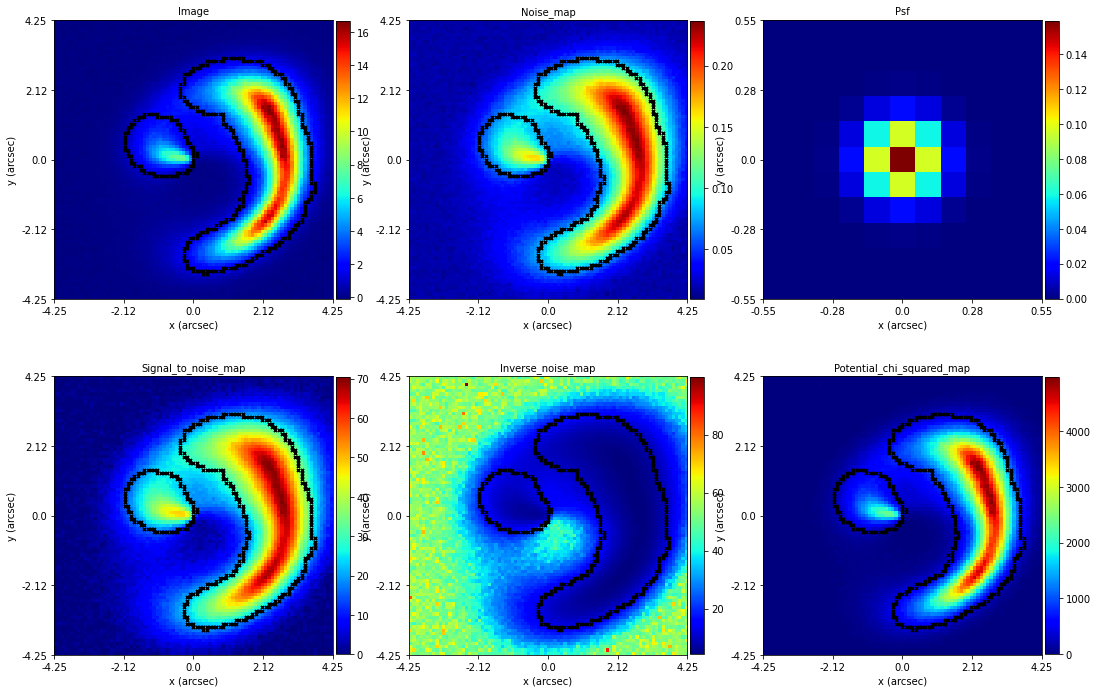

In [18]:
#Plot

aplt.Imaging.subplot_imaging(
    imaging=imaging, mask=mask_custom, include=aplt.Include(border=False),
)

In [19]:
# __Defining the MGE mass model__
#Initializing the MGE model for the lens

mass_profile = al.mp.MGE(centre=(0.0, 0.0))                                #Mass model
mass_profile.MGE_comps(M=Total_Mass.value, sigma=Total_sigma_RAD.value,
                       q=Total_q, z_l=z_lens, z_s=z_source)               #Input parameters

mass_profile.MGE_Grid_parameters(masked_imaging.grid)
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=0.02, phi=142) #external shear

lens_galaxy = al.Galaxy(
    redshift=z_lens,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

In [20]:
#Now we set the tracer to the source galaxy

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=z_source)])
source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_imaging.grid)[1]

Entrou
MainProcess 2.4990060329437256


We'll use the rectangular _Pixelization_ and _Mapper_ to perform the reconstruction.

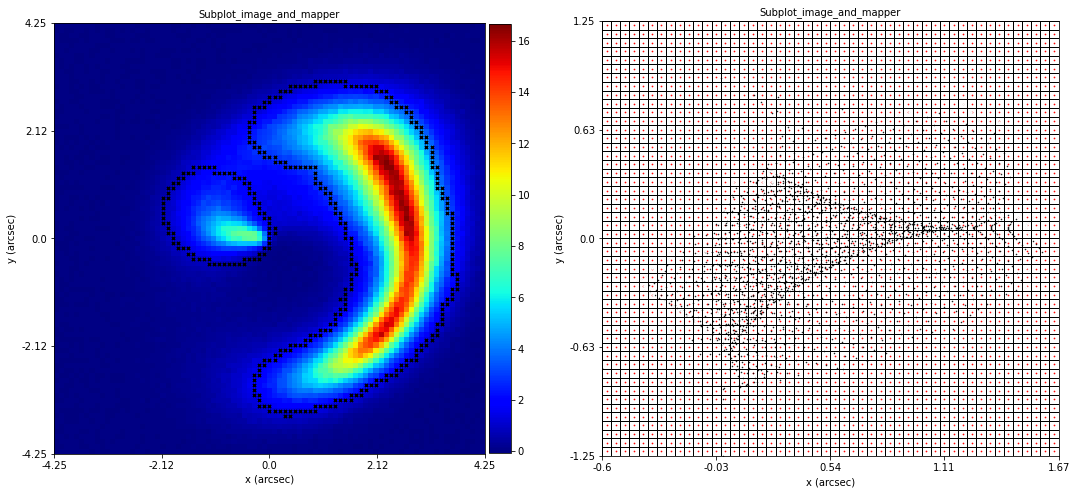

In [21]:
rectangular = al.pix.Rectangular(shape=(50, 50))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=True, inversion_grid=True),
)

And now, finally, we're going to use our _Mapper_ to invert the image using an _Inversion_.

In [22]:
inversion = al.Inversion(
    masked_dataset=masked_imaging,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=3.5),
)

Our _Inversion_ has a reconstructed image and _Pixeilzation_, whcih we can plot using an _Inversion_ plotter

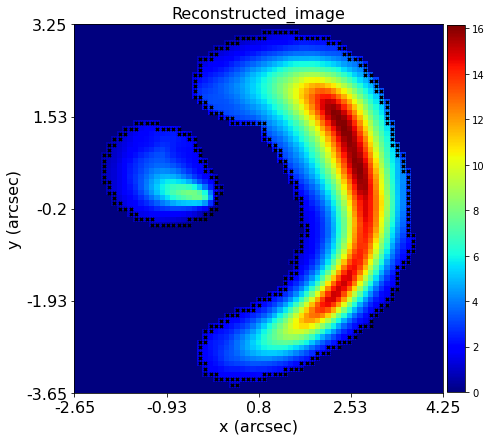

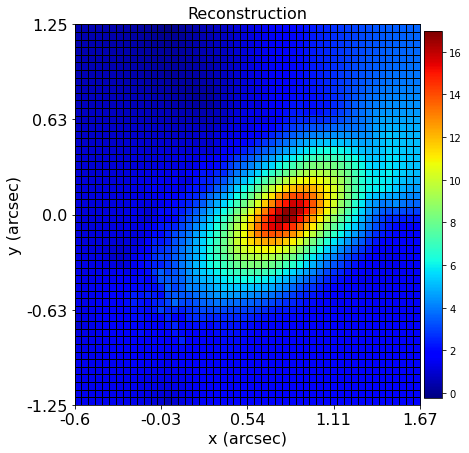

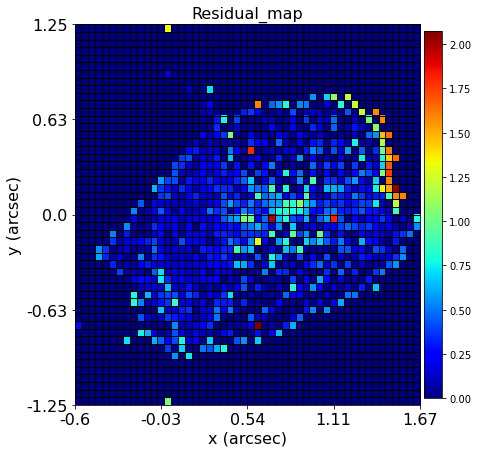

In [23]:
aplt.Inversion.reconstructed_image(inversion=inversion, include=aplt.Include(mask=True))

aplt.Inversion.reconstruction(
    inversion=inversion, include=aplt.Include(inversion_pixelization_grid=False, inversion_border=False)
)

aplt.Inversion.residual_map(inversion, include=aplt.Include(inversion_pixelization_grid=False,
                                                            inversion_border=False))

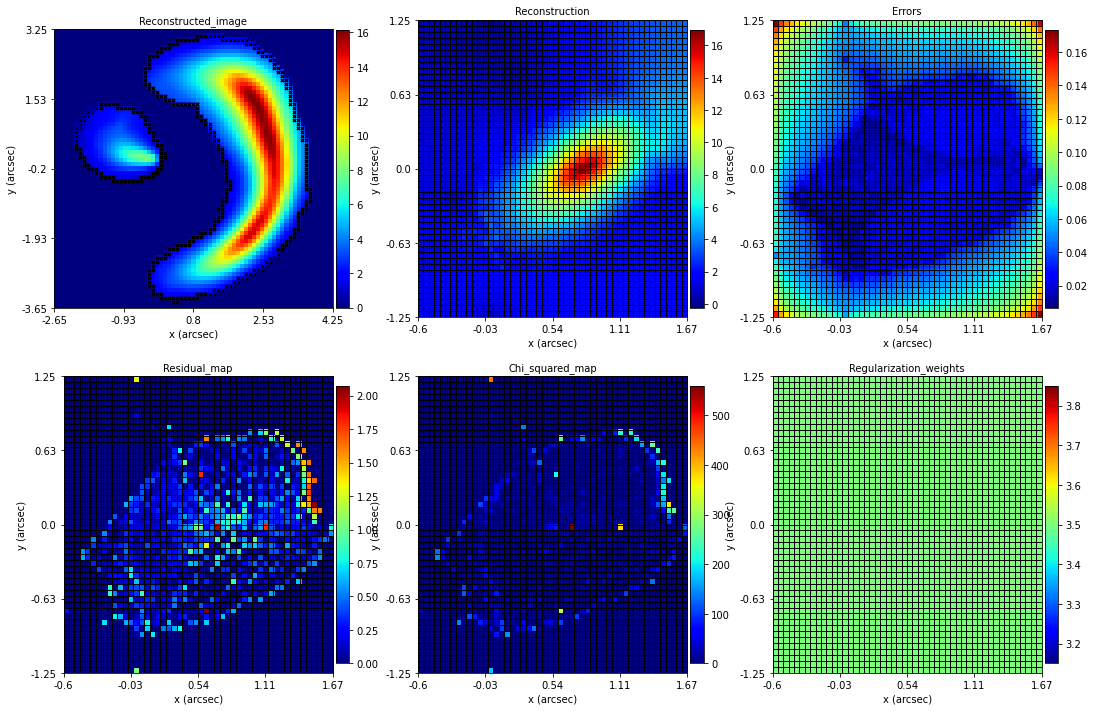

In [24]:
aplt.Inversion.subplot_inversion(inversion, include=aplt.Include(inversion_border=False,
                                                                 inversion_pixelization_grid=False))

## Voronoi Inversion

In [31]:

voronoi = al.pix.VoronoiMagnification(shape=(40,40))

image_plane_sparse_grid = voronoi.sparse_grid_from_grid(grid=masked_imaging.grid)

source_galaxy_voronoi = al.Galaxy(
    redshift=z_source, pixelization=voronoi, regularization=al.reg.Constant(coefficient=3.5)
)

tracer_voronoi = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy_voronoi])


Entrou
MainProcess 2.4368209838867188
Entrou
MainProcess 0.9854798316955566
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model


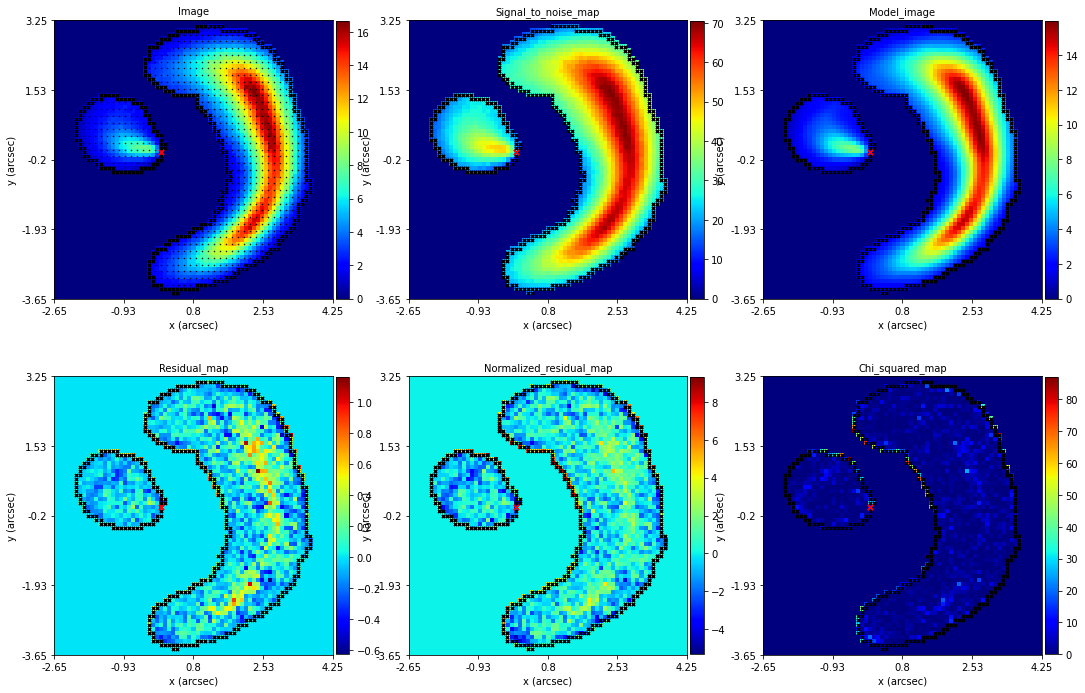

Critical curve could not be calculated due to an unphysical mass model
Entrou
MainProcess 2.4710733890533447
Entrou
MainProcess 2.1152358055114746
Entrou
MainProcess 2.4473750591278076
Entrou
MainProcess 2.1336820125579834
Entrou
MainProcess 2.509202718734741
Entrou
MainProcess 2.1302075386047363
Critical curve could not be calculated due to an unphysical mass model
Entrou
MainProcess 2.4697186946868896
Entrou
MainProcess 2.10382080078125
Critical curve could not be calculated due to an unphysical mass model
Caustics could not be calculated due to an unphysical mass model


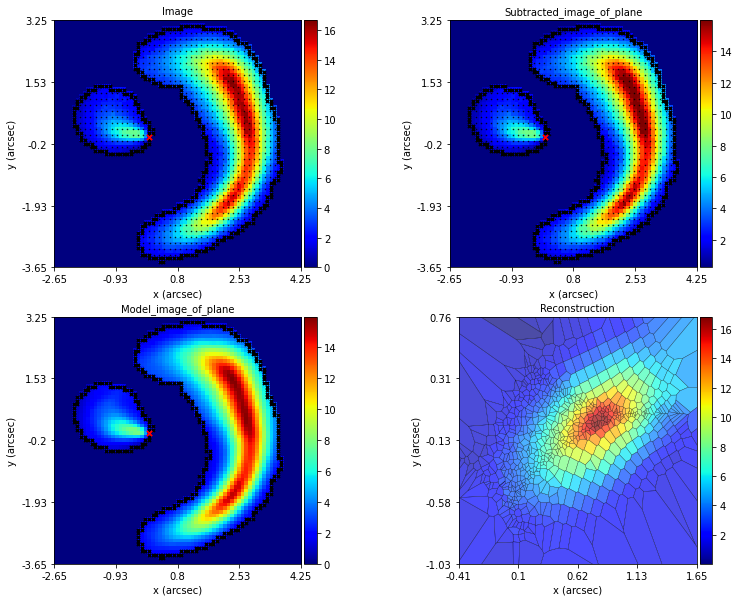

In [32]:
fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer_voronoi)

aplt.FitImaging.subplot_fit_imaging(
    fit=fit,
    include=aplt.Include(
        mask=True,
        inversion_image_pixelization_grid=True,
        inversion_pixelization_grid=True,
    ),
)
aplt.FitImaging.subplot_of_plane(
    fit=fit, plane_index=1, include=aplt.Include(mask=True, inversion_pixelization_grid=False,
                                                            inversion_border=False)
)